In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc

# Reading Data:

In [2]:
data = pd.read_csv("CollegeScorecard.csv")
data.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(7804, 1725)

# Encoding City Feature:

In [3]:
label_encoder = LabelEncoder()
  
data['CITY']= label_encoder.fit_transform(data['CITY']) 

# Exploring Na Values:
Droping Columns with more then 500 Na values

In [4]:
data[data == 'PrivacySuppressed'] = np.nan
nas = data.isna().sum(axis=0)
drop = list(nas[nas > 500].index.values)
data.drop(drop, axis=1,  inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# Corelation:

In [5]:
corr = data.corr()

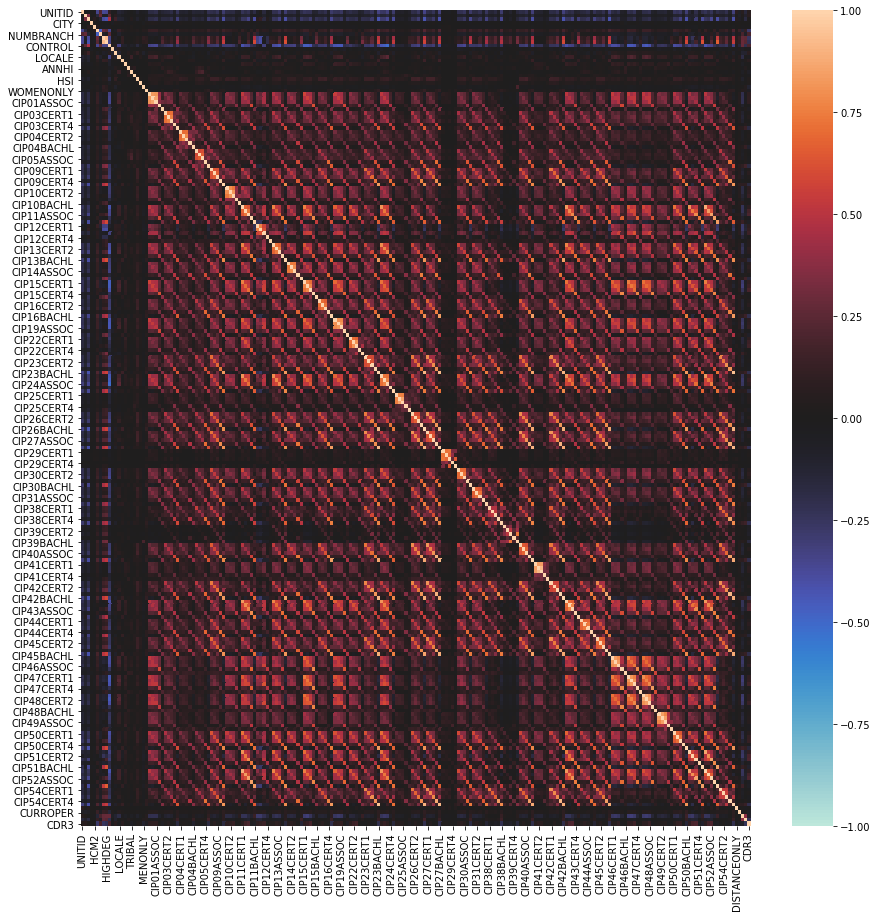

In [6]:
fig, axes = plt.subplots(figsize=(15, 15))
graph = sns.heatmap(corr, vmin=-1, vmax=1, center=0, ax=axes)
plt.show()

In [7]:
count =0
drop = list()
for i in range(0, corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if(abs(corr.iloc[i, j]) > 0.7):
            drop.append(corr.columns[i])
            count += 1
print(count)
data.drop(drop, axis=1, inplace=True)

359


# Droping Irrelevent Columns:
Region is encoded STABBAR
OPEID and opeid6 is Server related Values and both are same
Institution Name and URL are unique for all

In [8]:
data.drop(["UNITID", "INSTURL", "INSTNM", "ZIP", "OPEID", "opeid6", "STABBR"], axis=1, inplace=True)

# Rows with large number of missing values:
there are aprox 400 rows with 89 missing features among 106 colums
which means we have only 17 values for that observations amoung them 3 are the unique Identifier

In [9]:
nas = data.isna().sum(axis=1)
data.drop(list(nas[nas>10].index), axis=0, inplace=True)
data.APPL_SCH_N = pd.to_numeric(data.APPL_SCH_N)

# Interpoltation:

In [10]:
nas = data.isna().sum(axis=0)
print(nas[nas>0])
NaIndex = nas[nas>0].index

LOCALE          3
TUITFTE        21
INEXPFTE       21
CDR3           61
APPL_SCH_N    317
dtype: int64


# Selecting Features with No NA


In [11]:
bolVar = list()
for i in range(data.shape[1]):
    if(data.columns[i] not in list(NaIndex)):
        bolVar.append(data.columns[i])
        

# Step of 2nd Iteration:
(PC 1 to PC 4) were City NumBranch, st_fips, Region with imp > 0.9
thats why removing these variable from PCA

In [12]:
bolVar.remove("CITY")
bolVar.remove("NUMBRANCH")
bolVar.remove("st_fips")
bolVar.remove("region")

In [13]:
X_bolVar = data[bolVar]
X_bolVar.shape

(7383, 91)

Checking NA values:

In [14]:
nas = X_bolVar.isna().sum()
nas[nas>0] 

Series([], dtype: int64)

# Scaling and PCA of Categorical variables

In [15]:
df_TF = StandardScaler().fit_transform(X_bolVar)
df_TF = pd.DataFrame(X_bolVar, columns=X_bolVar.columns)

Precentage Variance Defiened by First 9 Components:0.6040340315329562


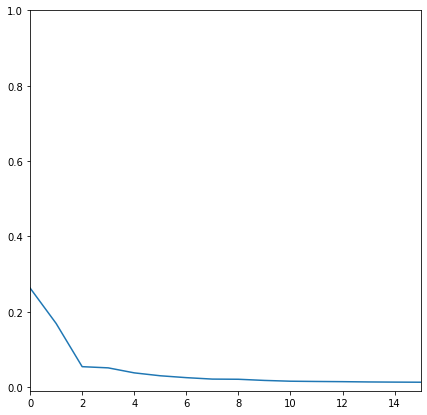

In [16]:
fit = PCA()
Pca = fit.fit_transform(df_TF)
plt.figure(figsize=(7, 7))
plt.ylim(-0.01, 1)
plt.xlim(0, 15)
plt.plot(fit.explained_variance_ratio_)
print("Precentage Variance Defiened by First 9 Components:" + str(fit.explained_variance_ratio_[:6].sum()))

In [17]:
print("Precentage Variance Defiened by First 9 Components:" + str(fit.explained_variance_ratio_[:6].sum()))

Precentage Variance Defiened by First 9 Components:0.6040340315329562


# Selecting 6 Variables among them:
Droping Features seleced for PCA and using PCA instead 

In [18]:
data.drop(list(X_bolVar.columns), axis=1, inplace=True)

In [19]:
cols = list()
for i in range(1, 7):
    cols.append("PC" + str(i))
pca = pd.DataFrame(Pca[:, :6], columns=cols)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


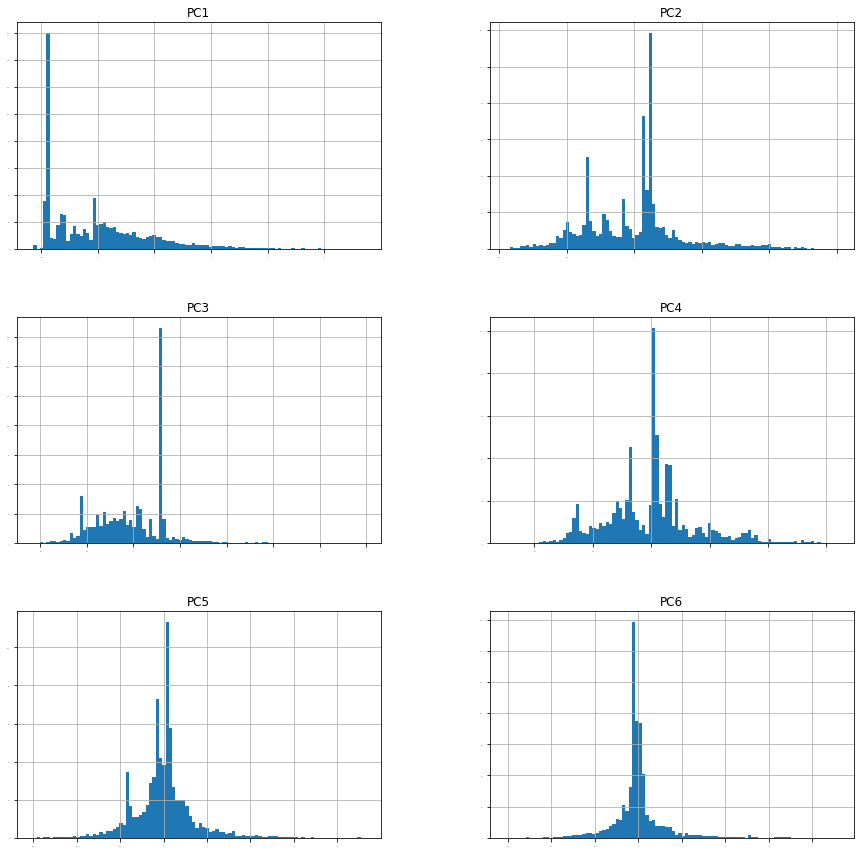

In [20]:
fig, axes = plt.subplots(figsize=(15, 15))
pca.hist(bins=100, xlabelsize=0.5, ylabelsize=0.5, ax=axes)
plt.show()

In [21]:
data = data.join(pca)

In [22]:
print(data.columns)
print(data.iloc[:, :6].isna().sum(axis=0))

Index(['CITY', 'NUMBRANCH', 'st_fips', 'region', 'LOCALE', 'TUITFTE',
       'INEXPFTE', 'CDR3', 'APPL_SCH_N', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6'],
      dtype='object')
CITY          0
NUMBRANCH     0
st_fips       0
region        0
LOCALE        3
TUITFTE      21
dtype: int64


# Component Analysis
Like this we can observe which PC is indicating which Features

In [51]:
Components = fit.components_[:6]
Components = pd.DataFrame(Components, index=cols, columns=X_bolVar.columns).T
print(Components.sort_values("PC1", axis=0, ascending=False).iloc[:5, 0])
print("************************")
print(Components.sort_values("PC2", axis=0, ascending=False).iloc[:5, 1])
print("************************")
print(Components.sort_values("PC3", axis=0, ascending=False).iloc[:5, 2])
print("************************")
print(Components.sort_values("PC4", axis=0, ascending=False).iloc[:5, 3])
print("************************")
print(Components.sort_values("PC5", axis=0, ascending=False).iloc[:5, 4])
print("************************")
print(Components.sort_values("PC6", axis=0, ascending=False).iloc[:5, 5])

HIGHDEG       0.460008
CIP52ASSOC    0.287089
CIP52BACHL    0.245376
CIP50ASSOC    0.227511
CIP54BACHL    0.178871
Name: PC1, dtype: float64
************************
CIP52CERT2    0.247838
CIP12CERT2    0.229951
CIP52CERT1    0.216905
CIP52ASSOC    0.207319
CIP12ASSOC    0.196692
Name: PC2, dtype: float64
************************
CIP54BACHL    0.267409
CIP54ASSOC    0.238302
CONTROL       0.214343
CIP03BACHL    0.207369
CIP40ASSOC    0.205380
Name: PC3, dtype: float64
************************
CONTROL       0.681303
CIP52ASSOC    0.356839
CIP22ASSOC    0.273942
CIP52BACHL    0.227582
CIP22BACHL    0.178467
Name: PC4, dtype: float64
************************
CIP52BACHL    0.294564
CIP22BACHL    0.289388
CIP15BACHL    0.278265
CIP52CERT2    0.232496
CIP12CERT2    0.216471
Name: PC5, dtype: float64
************************
CIP52CERT1    0.460983
CIP44CERT1    0.384139
CIP30CERT1    0.331973
CIP54CERT1    0.237575
CIP31CERT1    0.225554
Name: PC6, dtype: float64


# Interpolation:
interpolating values using KNN<br> 
a) LOCALE

In [24]:
index = data.LOCALE[data.LOCALE.isna()].index
locale = data.drop(["TUITFTE", "INEXPFTE", "CDR3", "APPL_SCH_N"], axis=1)

train = locale[np.logical_not(locale.LOCALE.isna())]
train_X = train.iloc[:, train.columns != 'LOCALE']
train_y = train.LOCALE
test_X = locale[locale.LOCALE.isna()]

neigh = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
neigh = neigh.fit(train_X, train_y)
print("Accuracy: ", neigh.score(train_X, train_y))

predicted = neigh.predict(test_X.drop("LOCALE", axis=1))
j =0 
for i in index:
    data.loc[i, "LOCALE"] = round(predicted[j])
    j += 1

Accuracy:  0.5895663956639566


b) TUITFTE

In [25]:
index = data.TUITFTE[data.TUITFTE.isna()].index
tui = data.drop(["INEXPFTE", "CDR3", "APPL_SCH_N"], axis=1)

train = tui[np.logical_not(tui.TUITFTE.isna())]
train_X = train.iloc[:, train.columns != 'TUITFTE']
train_y = train.TUITFTE
test_X = tui[tui.TUITFTE.isna()]

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
neigh = neigh.fit(train_X, train_y)
print("Accuracy: ", neigh.score(train_X, train_y))

predicted = neigh.predict(test_X.drop("TUITFTE", axis=1))
j =0 
for i in index:
    data.loc[i, "TUITFTE"] = round(predicted[j])
    j += 1

Accuracy:  0.22940731549972837


c) INEXPFTE

In [26]:
index = data.INEXPFTE[data.INEXPFTE.isna()].index
ine = data.drop(["CDR3", "APPL_SCH_N"], axis=1)

train = ine[np.logical_not(ine.INEXPFTE.isna())]
train_X = train.iloc[:, train.columns != 'INEXPFTE']
train_y = train.INEXPFTE
test_X = ine[ine.INEXPFTE.isna()]

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
neigh = neigh.fit(train_X, train_y)
print("Accuracy: ", neigh.score(train_X, train_y))

predicted = neigh.predict(test_X.drop("INEXPFTE", axis=1))
j =0 
for i in index:
    data.loc[i, "INEXPFTE"] = round(predicted[j])
    j += 1

Accuracy:  0.24779624124915245


d) CDR3

In [27]:
index = data.CDR3[data.CDR3.isna()].index
ine = data.drop(["APPL_SCH_N"], axis=1)

train = ine[np.logical_not(ine.CDR3.isna())]
train_X = train.iloc[:, train.columns != 'INEXPFTE']
train_y = train.CDR3
test_X = ine[ine.CDR3.isna()]

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
neigh = neigh.fit(train_X, train_y)
print("Accuracy: ", neigh.score(train_X, train_y))

predicted = neigh.predict(test_X.drop("CDR3", axis=1))
j =0 
for i in index:
    data.loc[i, "CDR3"] = abs(round(predicted[j]))
    j += 1

Accuracy:  0.13077609983433802


e) APPL_SCH_N

In [28]:
index = data.APPL_SCH_N[data.APPL_SCH_N.isna()].index
ine = data

train = ine[np.logical_not(ine.APPL_SCH_N.isna())]
train_X = train.iloc[:, train.columns != 'APPL_SCH_N']
train_y = train.APPL_SCH_N
test_X = ine[ine.APPL_SCH_N.isna()]

neigh = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
neigh = neigh.fit(train_X, train_y)
print("Accuracy: ", neigh.score(train_X, train_y))

predicted = neigh.predict(test_X.drop("APPL_SCH_N", axis=1))
j =0 
for i in index:
    data.loc[i, "APPL_SCH_N"] = abs(round(predicted[j]))
    j += 1

Accuracy:  0.37820964498765464


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


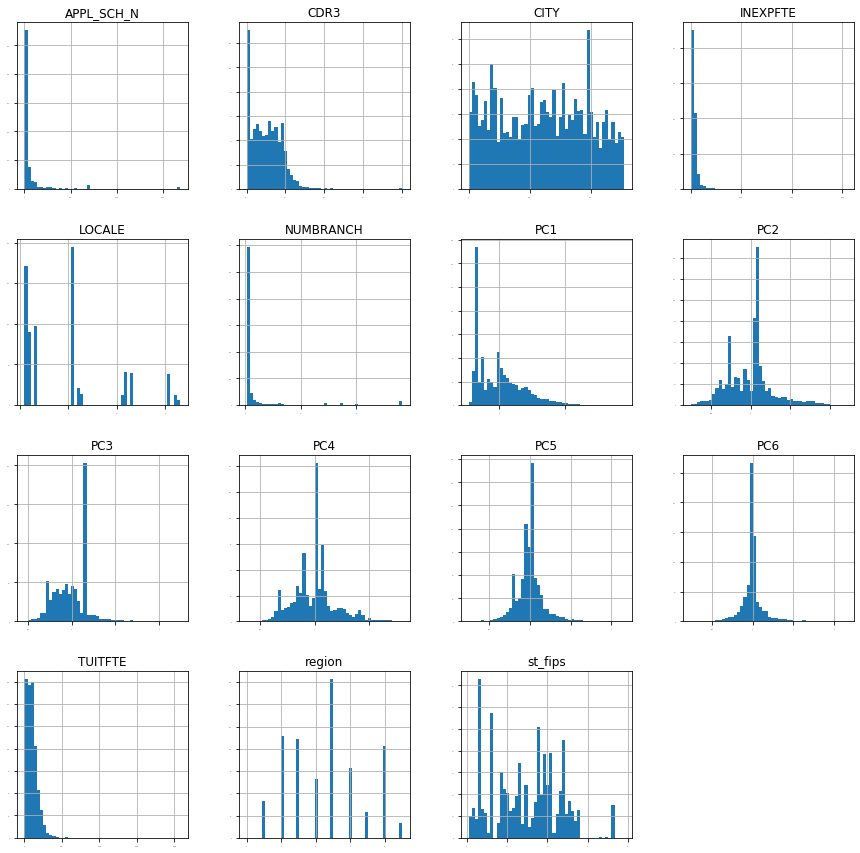

In [29]:
fig, axes = plt.subplots(figsize=(15, 15))
data.hist(bins=50, xlabelsize=0.25, ylabelsize=0.25, ax=axes)
plt.show()

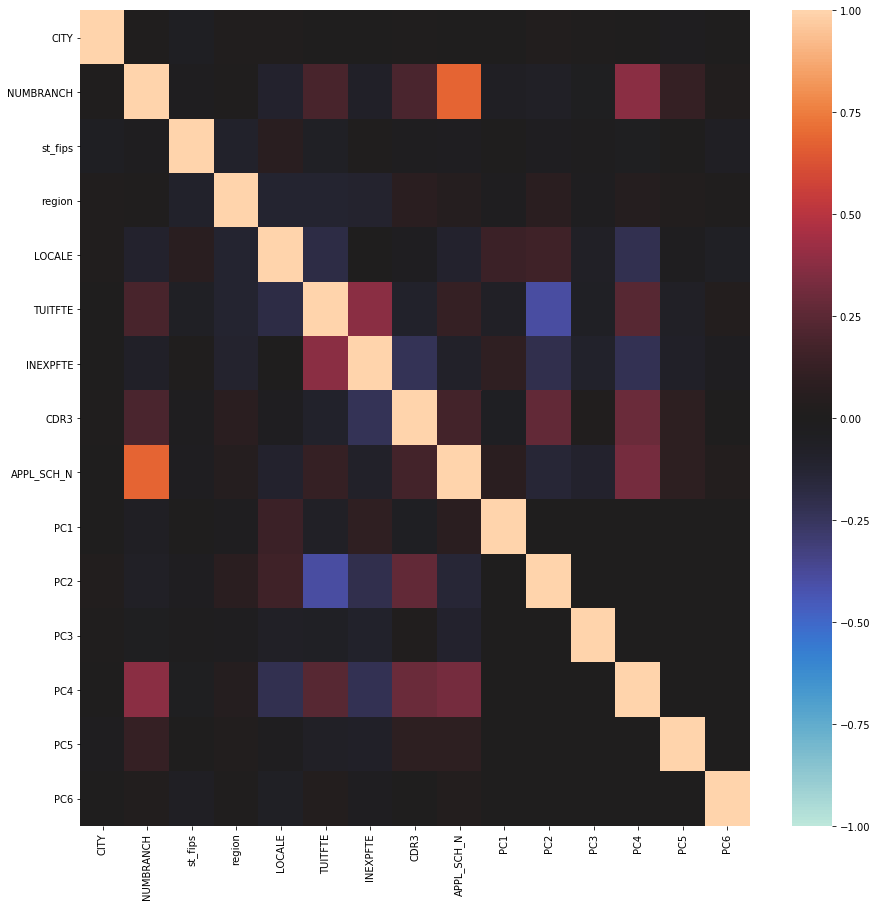

In [30]:
corr = data.corr()
fig, axes = plt.subplots(figsize=(15, 15))
graph = sns.heatmap(corr, vmin=-1, vmax=1, center=0, ax=axes)
plt.show()

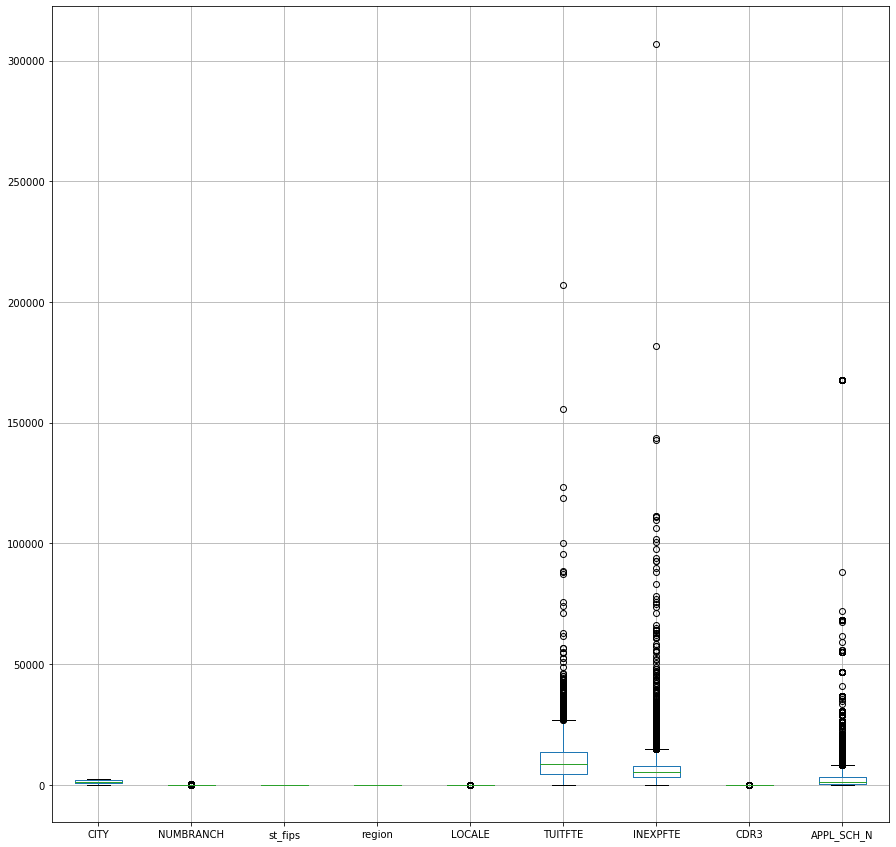

In [31]:
fig, axes = plt.subplots(figsize=(15, 15))
data.iloc[:, :9].boxplot(ax=axes)

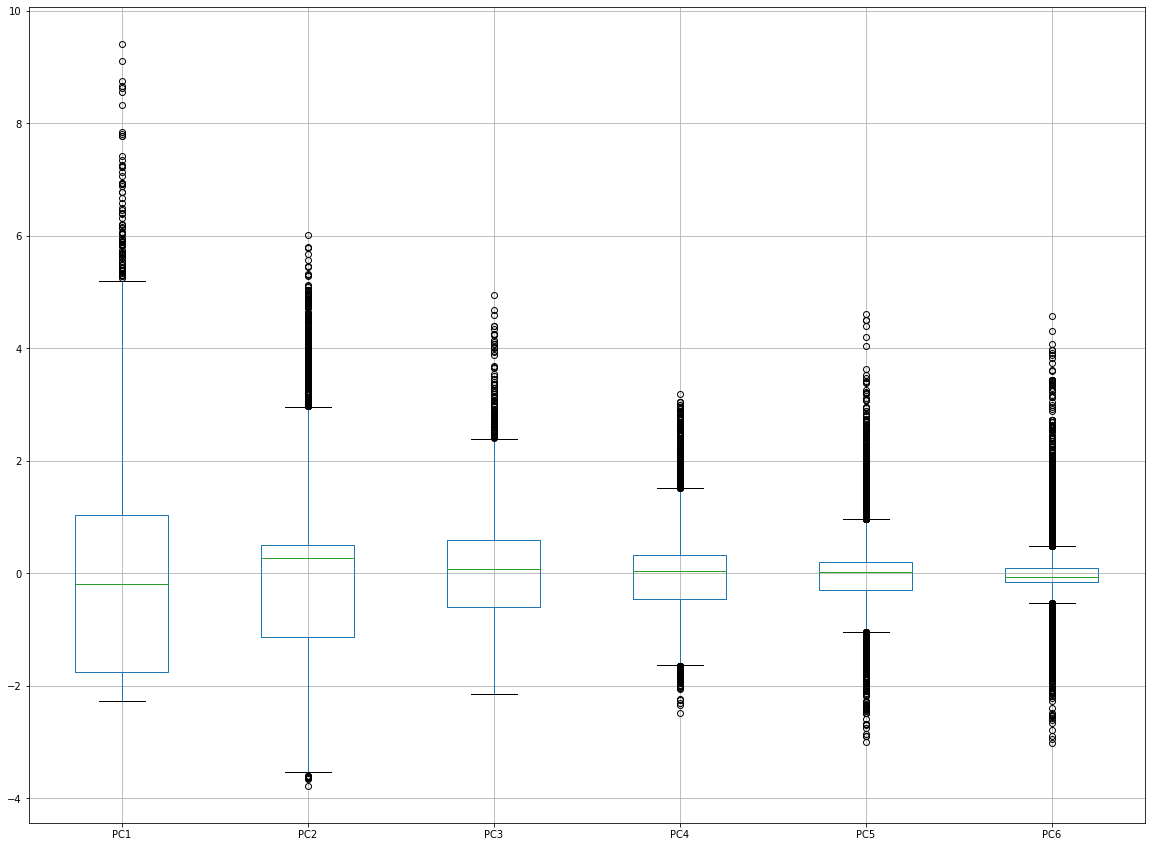

In [32]:
fig, axes = plt.subplots(figsize=(20, 15))
data.iloc[:, 9:].boxplot(ax=axes)

# Second Iteration
detected outliers in Visualization so deleting points that are wide spreaded
To Reproduce, comment out the below box

In [33]:
fit2 = PCA(2)
Pca2 = fit2.fit_transform(data)
Viz_data = pd.DataFrame(Pca2, columns=["X1", "X2"])
IndDrop = list(Viz_data[np.logical_or(Viz_data.X1 > 7500 , Viz_data.X2 > 75000)].index)
data.drop(IndDrop, axis=0, inplace=True)

In [34]:
kmeans = KMeans(n_clusters=3)
data_scaled = normalize(data)
kmeans.fit(data_scaled)

labels = kmeans.predict(data_scaled)
centroids = kmeans.cluster_centers_

# Visualization:


In [35]:
fit2 = PCA(2)
Pca2 = fit2.fit_transform(data_scaled)
Viz_data = pd.DataFrame(Pca2, columns=["X1", "X2"])

In [36]:
Viz_data["Label"] = labels

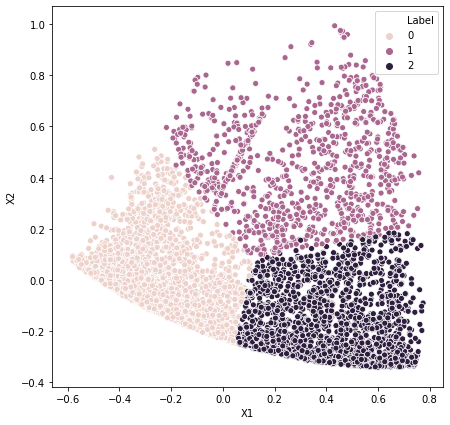

In [42]:
fig, axes = plt.subplots(figsize=(7, 7))
sns.scatterplot(x="X1", y="X2", data=Viz_data, hue="Label", ax=axes)

In [39]:
linkage = shc.linkage(data_scaled, method='ward')

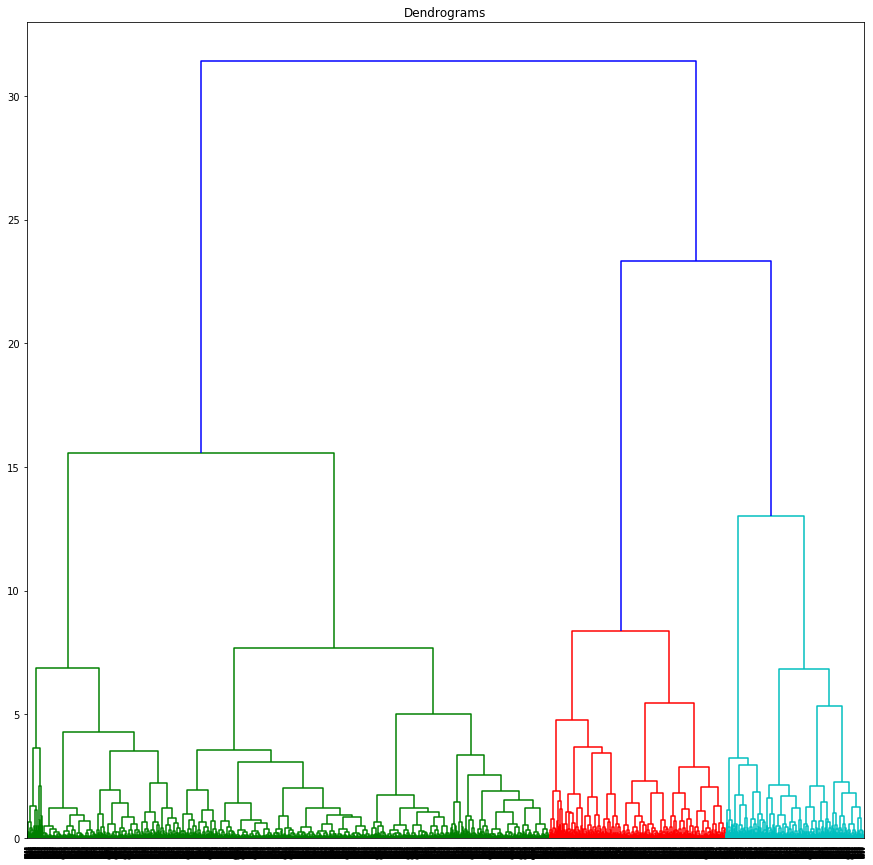

In [40]:
plt.figure(figsize=(15, 15))  
plt.title("Dendrograms")  
dend = shc.dendrogram(linkage)

# Cluster Analysis:

In [46]:
data["Label"] = labels

In [47]:
data.head()

,CITY,NUMBRANCH,st_fips,region,LOCALE,TUITFTE,INEXPFTE,CDR3,APPL_SCH_N,PC1,PC2,PC3,PC4,PC5,PC6,Label
0,1555,1,1,5,12.0,9063.0,7459.0,0.163,2422.0,1.869029,-2.855025,0.617989,-1.334234,2.183370,-0.882296,0
1,190,1,1,5,12.0,9033.0,17208.0,0.080,4689.0,2.037233,-2.184429,0.158393,-1.428295,0.796925,0.603072,2
2,1432,1,1,5,12.0,12057.0,5123.0,0.089,412.0,1.091295,-1.643262,-1.230026,0.875839,-0.346441,-0.210142,0
3,1009,1,1,5,12.0,8322.0,9352.0,0.077,1934.0,1.283778,-2.483181,-0.272000,-1.098554,0.317242,-0.248352,2
4,1432,1,1,5,12.0,7813.0,7393.0,0.191,3588.0,1.080177,-2.269944,-0.639342,-0.890405,-0.079963,-0.150192,0


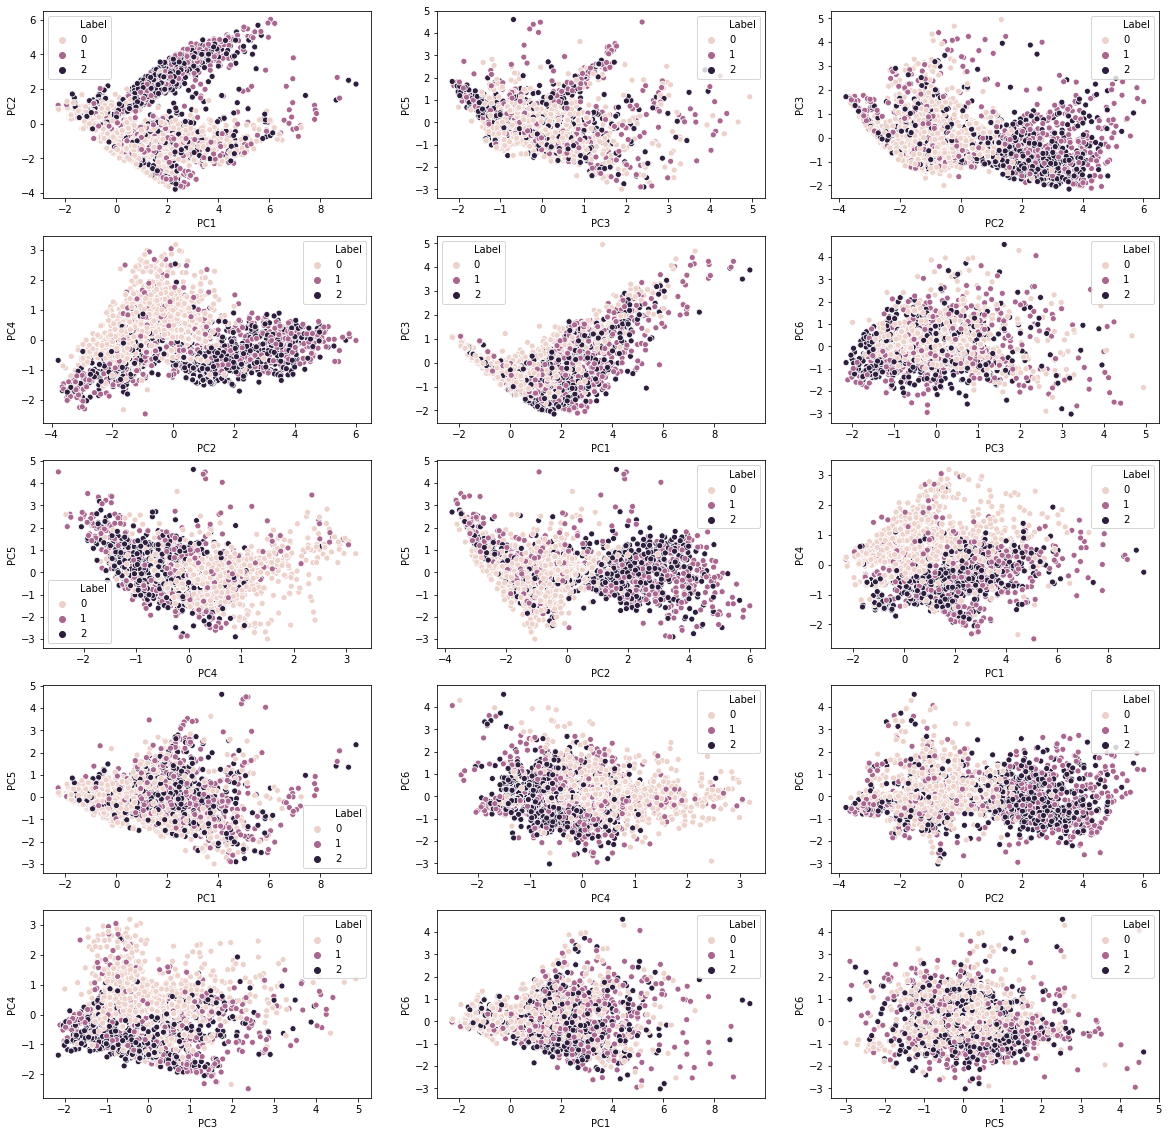

In [75]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
vars = list(["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
GraphY = 0
GraphX = 0
for i in range(6):
    for j in range(i+1, 6):
            GraphY = GraphY % 3
            GraphX = GraphX % 5
            sns.scatterplot(x=vars[i], y=vars[j], data=data, hue="Label", ax=axes[GraphX, GraphY])
            GraphX += 1
            GraphY +=1

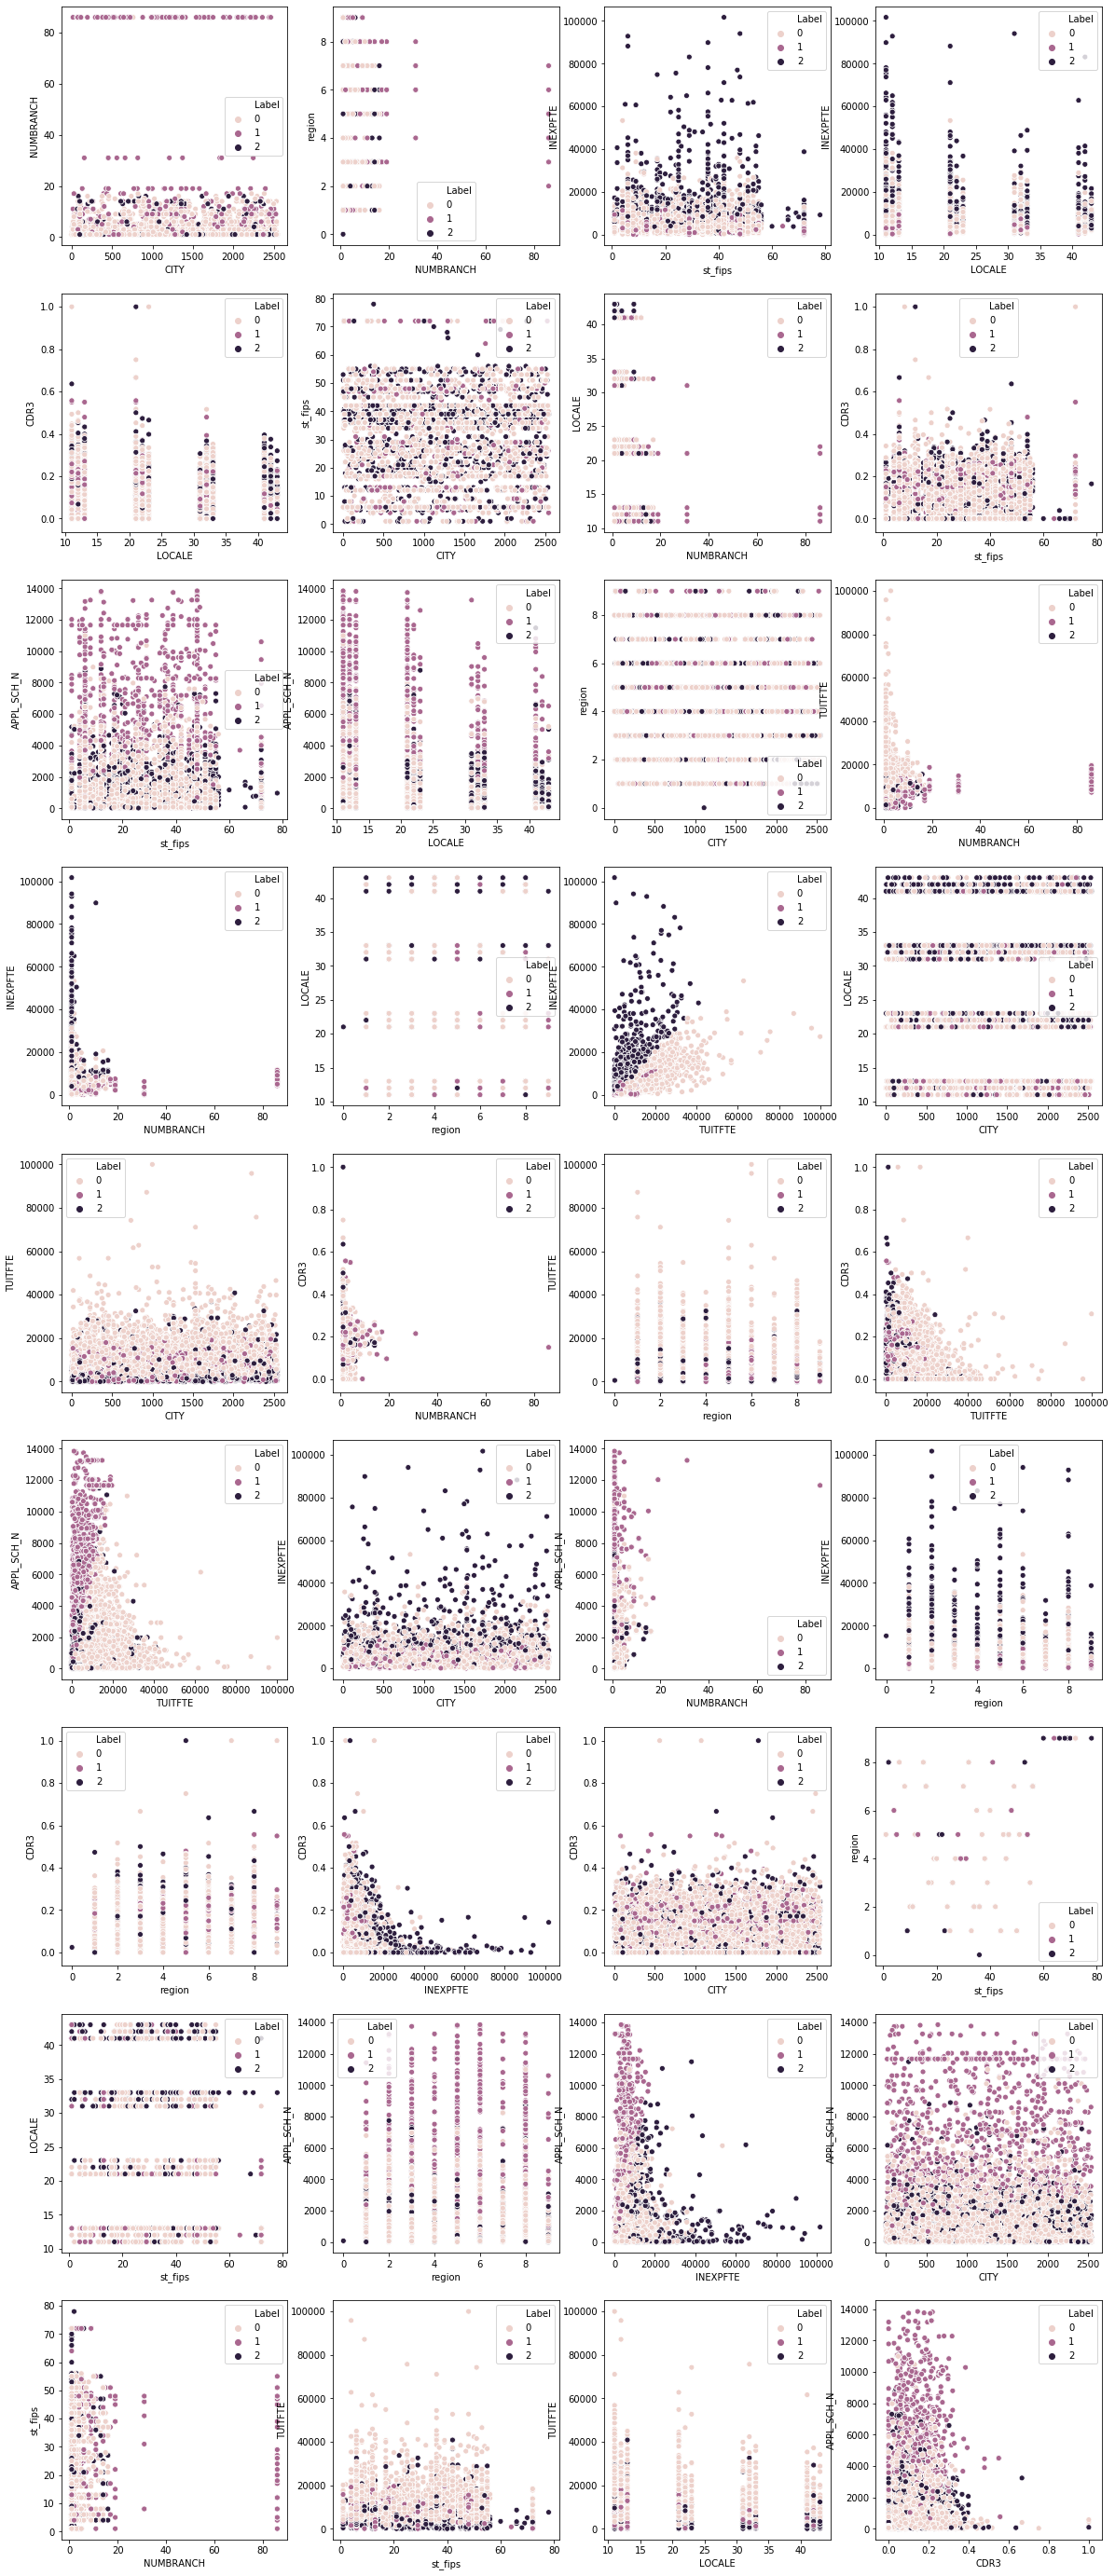

In [108]:
fig, axes = plt.subplots(9, 4, figsize=(20, 50))
vars = list(["CITY", "NUMBRANCH", "st_fips", "region", "LOCALE", "TUITFTE", "INEXPFTE", "CDR3", "APPL_SCH_N"])
GraphY = 0
GraphX = 0
for i in range(9):
    for j in range(i+1, 9):
        GraphY = GraphY % 4
        GraphX = GraphX % 9
        sns.scatterplot(x=vars[i], y=vars[j], data=data, hue="Label", ax=axes[GraphX, GraphY])
        GraphX += 1
        GraphY +=1

# Observations From Graphs:
# Cluster 0:
high PC4, TUITFTE<br>
Low PC2, Low PC1, low NUMBRANCH<br>
Low INEXPFTE and Low CDR3<br>
Low Region
# Cluster 1:
high NUMBRANCH<br>
high APPL_SCH_N<br>
high APPL_SCH_N and Low TUITFTE<br>
Low TUITFTE and Mean CDR3<br>

# Cluster 2:
High PC2, High PC1, high INEXPFTE<br>
Low PC3, Low PC4, Low TUITFTE

# Mixed Cluster 1, 2
High PC2, Low PC4<br>

Where PC1, 2, 3, 4 are:
# PC1:
HIGHDEG<br>
CIP52ASSOC<br>
CIP52BACHL<br>
CIP50ASSOC<br>
CIP54BACHL<br>

# PC2:
CIP52CERT2<br>
CIP12CERT2<br>
CIP52CERT1<br>
CIP52ASSOC<br>
CIP12ASSOC<br>
# PC3:
CIP54BACHL<br>
CIP54ASSOC<br>
CONTROL<br>
CIP03BACHL<br>
CIP40ASSOC<br>
# PC4:
CONTROL<br>
CIP52ASSOC<br>
CIP22ASSOC<br>
CIP52BACHL<br>
CIP22BACHL<br>
